In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_facenet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.6 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10385 sha256=d6e2b6abcd55e0ec1643b1f7394bc4216b8b136b00894e6e9b2f7082b5980de3
  Stored in directory: /root/.cache/pip/wheels/73/5d/41/90b5d28ca667cfc4748ae859fa4f0b85b936d73207a073ded5
Successfully built keras_facenet


In [ ]:
import numpy as np
#from keras.preprocessing import image
import keras.utils as image
from keras.utils import load_img, img_to_array
import pandas as pd
from keras_facenet import FaceNet

# Read csv file contain image face paths
data = pd.read_csv("/content/drive/MyDrive/train_face/test_data/test_faces.csv")

images = data["vids_list"]
labels = data["label"]

train_data = []
train_label = []
count = 0

embedder = FaceNet()

for (img_path, label) in zip(images, labels):
     #x = load_img(img_path)
    #x = image.img_to_array(img_path)
    #x = np.expand_dims(x, axis=0)
    #embeddings = embedder.embeddings(x)
    #train_data.append(embeddings)
    train_label += [label]

    #if count % 10000 == 0:
    print("Number of files done:", count)
    count += 1

#train_data = np.array(train_data)
train_label = np.array(train_label)

#np.save("/content/drive/MyDrive/combined_data/train_face/train_data_facenet_embeddings.npy", train_data)
np.save("/content/drive/MyDrive/train_face/test_data/train_label_facenet_embeddings.npy", train_label)
print("Files saved....")


Number of files done: 0
Number of files done: 1
Number of files done: 2
Number of files done: 3
Number of files done: 4
Number of files done: 5
Number of files done: 6
Number of files done: 7
Number of files done: 8
Number of files done: 9
Number of files done: 10
Number of files done: 11
Number of files done: 12
Number of files done: 13
Number of files done: 14
Number of files done: 15
Number of files done: 16
Number of files done: 17
Number of files done: 18
Number of files done: 19
Number of files done: 20
Number of files done: 21
Number of files done: 22
Number of files done: 23
Files saved....


In [ ]:
import argparse
import pickle

## for Model definition/training
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam, Nadam
from keras.applications.xception import Xception
# from keras.applications.resnet_v2 import ResNet50V2
from keras import backend as K
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers.pooling import MaxPooling2D

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patheffects as PathEffects


In [ ]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

In [ ]:
def scatter(x, labels, subtitle=None):
	# We choose a color palette with seaborn.
	palette = np.array(sns.color_palette(flatui, 2))

	# We create a scatter plot.
	f = plt.figure(figsize=(8, 8))
	ax = plt.subplot(aspect="equal")
	sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[labels.astype(np.int)])
	plt.xlim(-25, 25)
	plt.ylim(-25, 25)
	ax.axis("off")
	ax.axis("tight")

	# We add the labels for each digit.
	txts = []
	for i in range(2):
		# Position of each label.
		xtext, ytext = np.median(x[labels == i, :], axis=0)
		txt = ax.text(xtext, ytext, str(i), fontsize=24)
		txt.set_path_effects(
			[PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
		)
		txts.append(txt)

	if subtitle != None:
		plt.suptitle(subtitle)

	plt.savefig(subtitle)


In [ ]:
def pairwise_distance(feature, squared=False):
	"""Computes the pairwise distance matrix with numerical stability.

	output[i, j] = || feature[i, :] - feature[j, :] ||_2

	Args:
	  feature: 2-D Tensor of size [number of data, feature dimension].
	  squared: Boolean, whether or not to square the pairwise distances.

	Returns:
	  pairwise_distances: 2-D Tensor of size [number of data, number of data].
	"""
	pairwise_distances_squared = math_ops.add(
		math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
		math_ops.reduce_sum(
			math_ops.square(array_ops.transpose(feature)),
			axis=[0],
			keepdims=True)) - 2.0 * math_ops.matmul(feature,
													array_ops.transpose(feature))

	# Deal with numerical inaccuracies. Set small negatives to zero.
	pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
	# Get the mask where the zero distances are at.
	error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

	# Optionally take the sqrt.
	if squared:
		pairwise_distances = pairwise_distances_squared
	else:
		pairwise_distances = math_ops.sqrt(
			pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

	# Undo conditionally adding 1e-16.
	pairwise_distances = math_ops.multiply(
		pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

	num_data = array_ops.shape(feature)[0]
	# Explicitly set diagonals to zero.
	mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
		array_ops.ones([num_data]))
	pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
	return pairwise_distances

def masked_maximum(data, mask, dim=1):
	"""Computes the axis wise maximum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the maximum.

	Returns:
	  masked_maximums: N-D `Tensor`.
		The maximized dimension is of size 1 after the operation.
	"""
	axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
	masked_maximums = math_ops.reduce_max(
		math_ops.multiply(data - axis_minimums, mask), dim,
		keepdims=True) + axis_minimums
	return masked_maximums

def masked_minimum(data, mask, dim=1):
	"""Computes the axis wise minimum over chosen elements.

	Args:
	  data: 2-D float `Tensor` of size [n, m].
	  mask: 2-D Boolean `Tensor` of size [n, m].
	  dim: The dimension over which to compute the minimum.

	Returns:
	  masked_minimums: N-D `Tensor`.
		The minimized dimension is of size 1 after the operation.
	"""
	axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
	masked_minimums = math_ops.reduce_min(
		math_ops.multiply(data - axis_maximums, mask), dim,
		keepdims=True) + axis_maximums
	return masked_minimums

In [ ]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
	del y_true
	margin = 1.
	labels = y_pred[:, :1]

 
	labels = tf.cast(labels, dtype='int32')

	embeddings = y_pred[:, 1:]

	### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
	
	# Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
	# lshape=array_ops.shape(labels)
	# assert lshape.shape == 1
	# labels = array_ops.reshape(labels, [lshape[0], 1])

	# Build pairwise squared distance matrix.
	pdist_matrix = pairwise_distance(embeddings, squared=True)
	# Build pairwise binary adjacency matrix.
	adjacency = math_ops.equal(labels, array_ops.transpose(labels))
	# Invert so we can select negatives only.
	adjacency_not = math_ops.logical_not(adjacency)

	# global batch_size  
	batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

	# Compute the mask.
	pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
	mask = math_ops.logical_and(
		array_ops.tile(adjacency_not, [batch_size, 1]),
		math_ops.greater(
			pdist_matrix_tile, array_ops.reshape(
				array_ops.transpose(pdist_matrix), [-1, 1])))
	mask_final = array_ops.reshape(
		math_ops.greater(
			math_ops.reduce_sum(
				math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
			0.0), [batch_size, batch_size])
	mask_final = array_ops.transpose(mask_final)

	adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
	mask = math_ops.cast(mask, dtype=dtypes.float32)

	# negatives_outside: smallest D_an where D_an > D_ap.
	negatives_outside = array_ops.reshape(
		masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
	negatives_outside = array_ops.transpose(negatives_outside)

	# negatives_inside: largest D_an.
	negatives_inside = array_ops.tile(
		masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
	semi_hard_negatives = array_ops.where(
		mask_final, negatives_outside, negatives_inside)

	loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

	mask_positives = math_ops.cast(
		adjacency, dtype=dtypes.float32) - array_ops.diag(
		array_ops.ones([batch_size]))

	# In lifted-struct, the authors multiply 0.5 for upper triangular
	#   in semihard, they take all positive pairs except the diagonal.
	num_positives = math_ops.reduce_sum(mask_positives)

	semi_hard_triplet_loss_distance = math_ops.truediv(
		math_ops.reduce_sum(
			math_ops.maximum(
				math_ops.multiply(loss_mat, mask_positives), 0.0)),
		num_positives,
		name='triplet_semihard_loss')
	
	### Code from Tensorflow function semi-hard triplet loss ENDS here.
	return semi_hard_triplet_loss_distance

def triplets_loss(y_true, y_pred):
	
#     embeddings = K.cast(embeddings, 'float32')
#     with sess.as_default():
#         print(embeddings.eval())
	
	embeddings = y_pred
	anchor_positive = embeddings[:10]
	negative = embeddings[10:]
#     print(anchor_positive)

	# Compute pairwise distance between all of anchor-positive
	dot_product = K.dot(anchor_positive, K.transpose(anchor_positive))
	square = K.square(anchor_positive)
	a_p_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product  + K.sum(K.transpose(square), axis=0) + 1e-6
	a_p_distance = K.maximum(a_p_distance, 0.0) ## Numerical stability
#     with K.get_session().as_default():
#         print(a_p_distance.eval())
#     print("Pairwise shape: ", a_p_distance)
#     print("Negative shape: ", negative)

	# Compute distance between anchor and negative
	dot_product_2 = K.dot(anchor_positive, K.transpose(negative))
	negative_square = K.square(negative)
	a_n_distance = K.reshape(K.sum(square, axis=1), (-1,1)) - 2.*dot_product_2  + K.sum(K.transpose(negative_square), axis=0)  + 1e-6
	a_n_distance = K.maximum(a_n_distance, 0.0) ## Numerical stability
	
	hard_negative = K.reshape(K.min(a_n_distance, axis=1), (-1, 1))
	
	distance = (a_p_distance - hard_negative + 0.2)
	loss = K.mean(K.maximum(distance, 0.0))/(2.)

#     with K.get_session().as_default():
#             print(loss.eval())
			
	return loss


In [ ]:
def create_base_network(image_input_shape, embedding_size):
	"""
	Base network to be shared (eq. to feature extraction).
	"""
	main_input = Input(shape=(512, ))
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(main_input)
	x = Dropout(0.1)(x)
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
	x = Dropout(0.1)(x)
	x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
	x = Dropout(0.1)(x)
	y = Dense(embedding_size)(x)
	base_network = Model(main_input, y)

	return base_network

In [ ]:
train_data = np.load("/content/drive/MyDrive/combined_data/train_data_facenet_embeddings.npy")
train_label = np.load("/content/drive/MyDrive/combined_data/train_label_facenet_embeddings.npy")
# train_label = train_label.argmax(1)
print("Dataset Loaded...")

x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, 
												  test_size=0.1, stratify=train_label,
												  random_state=34)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Dataset Loaded...
(27102, 1, 512) (27102,) (3012, 1, 512) (3012,)


In [ ]:
x=tf.squeeze(x_train)

In [ ]:
x.shape

TensorShape([27102, 512])

In [ ]:
tf.reshape(x_train[1], [-1, 512])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 1.53196072e-02,  1.64033228e-03,  1.26656443e-02,
         2.58586016e-02,  4.36136909e-02,  4.74458151e-02,
         1.37819173e-02,  5.08306548e-02, -8.14868044e-03,
        -5.96120441e-03, -1.02769816e-02, -8.29523355e-02,
        -1.15939369e-02, -4.39855037e-03,  4.71943095e-02,
        -8.42241477e-03, -4.97213751e-02,  4.04130556e-02,
        -1.32516120e-02,  7.19057992e-02,  2.53313384e-03,
         2.94179805e-02,  5.16550057e-03,  4.00325954e-02,
         9.93578322e-03,  5.51315174e-02,  1.87786426e-02,
        -1.40643362e-02,  1.02575775e-02, -3.26057896e-03,
         4.56919633e-02,  1.06676035e-01, -3.47055271e-02,
         1.36598581e-02,  1.26191556e-01, -6.19758032e-02,
         3.03632431e-02, -8.58597457e-02,  3.02245654e-02,
        -2.21562833e-02,  2.03554612e-03,  4.03386392e-02,
        -3.46388593e-02, -3.37844603e-02,  4.00376245e-02,
        -2.30550356e-02,  1.83479674e-02,  1.00093624e-02,
      

In [ ]:
x_train[1].shape

(1, 512)

In [ ]:
x_train[1].shape

(1, 512)

In [ ]:
batch_size = 32
epochs = 100
# train_flag = args["train_flag"]  # either     True or False
train_flag = "True"
# print(train_flag)

embedding_size = 64

no_of_components = 2  # for visualization -> PCA.fit_transform()

step = 10

# The data, split between train and test sets
train_data = np.load("/content/drive/MyDrive/combined_data/train_data_facenet_embeddings.npy")
train_label = np.load("/content/drive/MyDrive/combined_data/train_label_facenet_embeddings.npy")
# train_label = train_label.argmax(1)
print("Dataset Loaded...")

x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, 
												  test_size=0.1, stratify=train_label,
												  random_state=34)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_new=tf.squeeze(x_train)
print(x_new)


input_image_shape = (512,)
#input_image_shape=(1,512)
x_val = x_test[:1000, :]
y_val = y_test[:1000]
x_test = x_test[1000:, :]
y_test = y_test[1000:]
print("x_val", x_val.shape)
x_val_new=tf.squeeze(x_val)
	# Network training...
x_new_test=tf.squeeze(x_test)
base_network = create_base_network(input_image_shape, embedding_size)
for layer in base_network.layers:
			if layer.name.endswith('bn'):
				# print(layer.name)
				layer.trainable=False
base_network.summary()

input_images = Input(shape=input_image_shape, name='input_image')
print(input_image_shape) # input layer for images
input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
embeddings = base_network([input_images]) 
print(embeddings.shape)

print(input_labels.shape)              # output of network -> embeddings
labels_plus_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings
    #print(labels_plus_embeddings.shape)
		# Defining a model with inputs (images, labels) and outputs (labels_plus_embeddings)
model = Model(inputs=[input_images, input_labels],
					  outputs=labels_plus_embeddings)
model.summary()
		#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

		# train session
optimizer = Adam(lr=3e-4)

model.compile(loss=triplet_loss_adapted_from_tf,
					  optimizer=optimizer, metrics=["accuracy"])


		# Uses 'dummy' embeddings + dummy gt labels. Will be removed as soon as loaded, to free memory
dummy_gt_train = np.zeros((len(x_train), embedding_size + 1))
dummy_gt_val = np.zeros((len(x_val), embedding_size + 1))   
H = model.fit(
			x=[x_new,y_train],
			y=dummy_gt_train,
			batch_size=batch_size,
			epochs=epochs,
			validation_data=([x_val_new, y_val], dummy_gt_val)
			# callbacks=callbacks_list
			)
model.save("triplets_semi_hard.hdf5")
		


Dataset Loaded...
(27102, 1, 512) (27102,) (3012, 1, 512) (3012,)
tf.Tensor(
[[ 6.3935414e-02  8.2697514e-03 -4.1496422e-02 ... -7.4803852e-02
   2.2627775e-02 -1.9700905e-02]
 [ 4.8353579e-02  2.2976741e-02  5.4387949e-02 ...  3.8373679e-02
   9.7786020e-03  7.9368144e-02]
 [ 1.1766150e-02 -1.4726215e-02  3.3036319e-03 ...  4.6165057e-02
   4.6405509e-02 -2.2747193e-02]
 ...
 [-2.2998068e-02  1.4260169e-02  3.9709352e-02 ...  1.8041063e-02
  -5.9391651e-02 -3.5210978e-02]
 [-1.9574411e-02  6.3906615e-03 -7.4070771e-03 ...  2.6318502e-02
   4.4666618e-02 -7.6880582e-02]
 [-2.0848215e-02 -5.2435571e-05 -2.7017340e-02 ...  4.4409968e-02
   2.8620705e-02 -7.8791559e-02]], shape=(27102, 512), dtype=float32)
x_val (1000, 1, 512)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                   

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


847/847 [==============================] - 11s 11ms/step - loss: 0.1477 - accuracy: 0.5438 - val_loss: 0.0039 - val_accuracy: 0.5690
Epoch 2/100
847/847 [==============================] - 8s 10ms/step - loss: 0.0058 - accuracy: 0.5437 - val_loss: 6.1993e-04 - val_accuracy: 0.5690
Epoch 3/100
847/847 [==============================] - 8s 10ms/step - loss: 0.0032 - accuracy: 0.5437 - val_loss: 0.0019 - val_accuracy: 0.5690
Epoch 4/100
847/847 [==============================] - 9s 11ms/step - loss: 0.0028 - accuracy: 0.5438 - val_loss: 0.0000e+00 - val_accuracy: 0.5690
Epoch 5/100
847/847 [==============================] - 7s 9ms/step - loss: 0.0018 - accuracy: 0.5435 - val_loss: 0.0024 - val_accuracy: 0.5690
Epoch 6/100
847/847 [==============================] - 9s 10ms/step - loss: 0.0032 - accuracy: 0.5430 - val_loss: 0.0022 - val_accuracy: 0.5690
Epoch 7/100
847/847 [==============================] - 8s 9ms/step - loss: 0.0020 - accuracy: 0.5420 - val_loss: 0.0000e+00 - val_accuracy: 

In [ ]:
x_new_test=tf.squeeze(x_test)

In [ ]:
x_new_test.shape

TensorShape([2012, 512])

63/63 [==============================] - 0s 2ms/step
Embeddings before training
SGD Acc: 0.8330019880715706
63/63 [==============================] - 0s 2ms/step
Embeddings after training


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGD Acc: 1.0
RF Acc: 1.0
LG Acc: 1.0
KNN Acc: 1.0
Perceptron Acc: 1.0
DT Acc: 1.0


<ipython-input-5-8aabf5a2d4d9>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[labels.astype(np.int)])


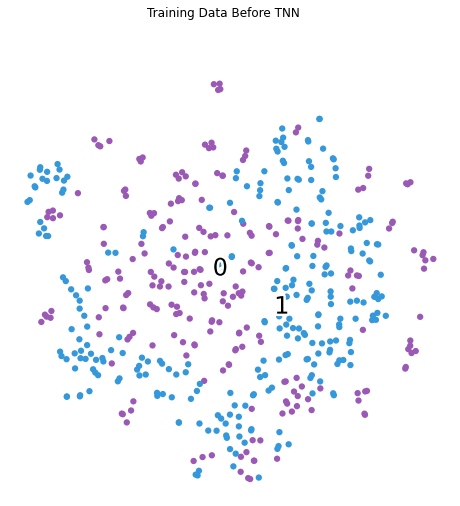

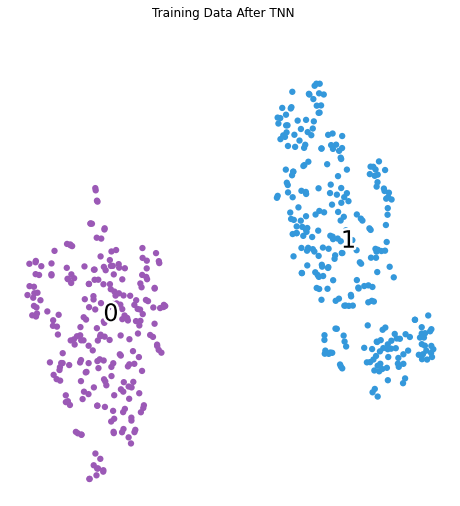

In [ ]:
testing_embeddings = create_base_network(input_image_shape,
												 embedding_size=embedding_size)
x_train_before = testing_embeddings.predict(x_new)
x_test_before = testing_embeddings.predict(x_new_test)

print("Embeddings before training")
sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
sgd.fit(x_train_before, y_train)
Y_pred = sgd.predict(x_test_before)
acc_sgd = accuracy_score(y_test, Y_pred)
print("SGD Acc:", acc_sgd)

		# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
		weights = layer_source.get_weights()
		layer_target.set_weights(weights)
		del weights        

x_train_after = testing_embeddings.predict(x_new)
x_test_after = testing_embeddings.predict(x_new_test)

print("Embeddings after training")
sgd = linear_model.SGDClassifier(max_iter=50, tol=None, loss="log")
		
sgd.fit(x_train_after, y_train)
Y_pred = sgd.predict(x_test_after)
acc_sgd = accuracy_score(y_test, Y_pred)
print("SGD Acc:", acc_sgd)
with open('sgd_classifier.pkl', 'wb') as fid:
		pickle.dump(sgd, fid)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train_after, y_train)
y_pred = rf.predict(x_test_after)
acc_rf = accuracy_score(y_test, y_pred)
print("RF Acc:", acc_rf)
with open('rf_classifier.pkl', 'wb') as fid:
      pickle.dump(rf, fid) 

logreg = LogisticRegression()
logreg.fit(x_train_after, y_train)
y_pred = logreg.predict(x_test_after)
acc_lg = accuracy_score(y_test, y_pred)
print("LG Acc:", acc_lg)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train_after, y_train)
y_pred = knn.predict(x_test_after)
acc_knn = accuracy_score(y_test, y_pred)
print("KNN Acc:", acc_knn)

perceptron = Perceptron(max_iter=15)
perceptron.fit(x_train_after, y_train)
y_pred = perceptron.predict(x_test_after)
acc_per = accuracy_score(y_test, y_pred)
print("Perceptron Acc:", acc_per)

dt = DecisionTreeClassifier()
dt.fit(x_train_after, y_train)
y_pred = dt.predict(x_test_after)
acc_dt = accuracy_score(y_test, y_pred)
print("DT Acc:", acc_dt)


embed = "TSNE"

if embed=="TSNE":
			tsne = TSNE()
			train_tsne_embeds_before_train = tsne.fit_transform(x_train_before[:512])
			train_tsne_embeds_after_train = tsne.fit_transform(x_train_after[:512])
			scatter(train_tsne_embeds_before_train, y_train[:512], "Training Data Before TNN")
			scatter(train_tsne_embeds_after_train, y_train[:512], "Training Data After TNN")

else:

			dict_embeddings = {}
			dict_gray = {}
			test_class_labels = np.unique(np.array(y_test))

			pca = PCA(n_components=no_of_components)
			decomposed_embeddings = pca.fit_transform(x_embeddings)
			print(decomposed_embeddings.shape)
			print(decomposed_embeddings[y_test == 1].shape)
			decomposed_gray = pca.fit_transform(x_embeddings_before_train)
			
			fig = plt.figure(figsize=(16, 8))
			for label in test_class_labels:
				decomposed_embeddings_class = decomposed_embeddings[y_test == label]
				decomposed_gray_class = decomposed_gray[y_test == label]

				plt.subplot(1,2,1)
				plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
				plt.title('before training (embeddings)')
				plt.legend()

				plt.subplot(1,2,2)
				plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
				plt.title('after @%d epochs' % epochs)
				plt.legend()
			plt.savefig('final learning')



In [ ]:
##### testing - evaluate triplets #####

In [ ]:
pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.8 MB/s eta 0:00:00


In [ ]:
import argparse
import pickle
import pandas as pd
import warnings
import imageio.core.util

from PIL import Image
import pandas as pd
import cv2
import math
## for Model definition/training
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from keras.optimizers import Adam, Nadam
from keras.applications.xception import Xception
from keras import backend as K
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers.pooling import MaxPooling2D
from keras import utils

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.patheffects as PathEffects
from facenet_pytorch import MTCNN
from keras_facenet import FaceNet


In [ ]:
def ignore_warnings(*args, **kwargs):
	pass

imageio.core.util._precision_warn = ignore_warnings

# Create face detector
mtcnn = MTCNN(margin=40, select_largest=False, post_process=False, device='cuda:0')

In [ ]:
def pairwise_distance(feature, squared=False): 
	pairwise_distances_squared = math_ops.add(
		math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
		math_ops.reduce_sum(
			math_ops.square(array_ops.transpose(feature)),
			axis=[0],
			keepdims=True)) - 2.0 * math_ops.matmul(feature,
													array_ops.transpose(feature))

	# Deal with numerical inaccuracies. Set small negatives to zero.
	pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
	# Get the mask where the zero distances are at.
	error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

	# Optionally take the sqrt.
	if squared:
		pairwise_distances = pairwise_distances_squared
	else:
		pairwise_distances = math_ops.sqrt(
			pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

	# Undo conditionally adding 1e-16.
	pairwise_distances = math_ops.multiply(
		pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

	num_data = array_ops.shape(feature)[0]
	# Explicitly set diagonals to zero.
	mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
		array_ops.ones([num_data]))
	pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
	return pairwise_distances

def masked_maximum(data, mask, dim=1):

	axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
	masked_maximums = math_ops.reduce_max(
		math_ops.multiply(data - axis_minimums, mask), dim,
		keepdims=True) + axis_minimums
	return masked_maximums

def masked_minimum(data, mask, dim=1):
	
	axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
	masked_minimums = math_ops.reduce_min(
		math_ops.multiply(data - axis_maximums, mask), dim,
		keepdims=True) + axis_maximums
	return masked_minimums


In [ ]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
	del y_true
	margin = 1.
	labels = y_pred[:, :1]

 
	labels = tf.cast(labels, dtype='int32')

	embeddings = y_pred[:, 1:]


	# Build pairwise squared distance matrix.
	pdist_matrix = pairwise_distance(embeddings, squared=True)
	# Build pairwise binary adjacency matrix.
	adjacency = math_ops.equal(labels, array_ops.transpose(labels))
	# Invert so we can select negatives only.
	adjacency_not = math_ops.logical_not(adjacency)

	# global batch_size  
	batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

	# Compute the mask.
	pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
	mask = math_ops.logical_and(
		array_ops.tile(adjacency_not, [batch_size, 1]),
		math_ops.greater(
			pdist_matrix_tile, array_ops.reshape(
				array_ops.transpose(pdist_matrix), [-1, 1])))
	mask_final = array_ops.reshape(
		math_ops.greater(
			math_ops.reduce_sum(
				math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
			0.0), [batch_size, batch_size])
	mask_final = array_ops.transpose(mask_final)

	adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
	mask = math_ops.cast(mask, dtype=dtypes.float32)

	# negatives_outside: smallest D_an where D_an > D_ap.
	negatives_outside = array_ops.reshape(
		masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
	negatives_outside = array_ops.transpose(negatives_outside)

	# negatives_inside: largest D_an.
	negatives_inside = array_ops.tile(
		masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
	semi_hard_negatives = array_ops.where(
		mask_final, negatives_outside, negatives_inside)

	loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

	mask_positives = math_ops.cast(
		adjacency, dtype=dtypes.float32) - array_ops.diag(
		array_ops.ones([batch_size]))

	# In lifted-struct, the authors multiply 0.5 for upper triangular
	#   in semihard, they take all positive pairs except the diagonal.
	num_positives = math_ops.reduce_sum(mask_positives)

	semi_hard_triplet_loss_distance = math_ops.truediv(
		math_ops.reduce_sum(
			math_ops.maximum(
				math_ops.multiply(loss_mat, mask_positives), 0.0)),
		num_positives,
		name='triplet_semihard_loss')
	
	### Code from Tensorflow function semi-hard triplet loss ENDS here.
	return semi_hard_triplet_loss_distance

In [ ]:
def create_base_network(image_input_shape, embedding_size):
	"""
	Base network to be shared (eq. to feature extraction).
	"""
	main_input = Input(shape=(512, ))
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(main_input)
	x = Dropout(0.1)(x)
	x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
	x = Dropout(0.1)(x)
	x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
	x = Dropout(0.1)(x)
	y = Dense(embedding_size)(x)
	base_network = Model(main_input, y)
	return base_network


Dataset Loaded...
24 24
Model Loaded...
(25, 160, 160, 3)
1/1 [==============================] - 0s 94ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 20ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 21ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 18ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 19ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 27ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 27ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 19ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 18ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 19ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [===========================

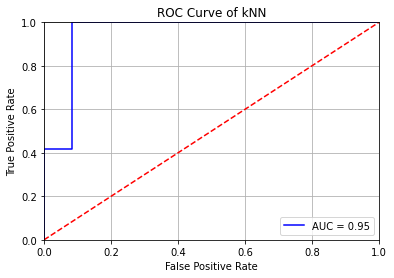

In [ ]:
embedding_size = 64
input_image_shape = (512, )
test_data = pd.read_csv("/content/drive/MyDrive/train_face/test_data/test_faces.csv")

embedder = FaceNet()

videos = test_data["vids_list"]
true_labels = test_data["label"]
print("Dataset Loaded...")
print(len(videos), len(true_labels))
# Test the network
# creating an empty network
testing_embeddings = create_base_network(input_image_shape,
                      embedding_size=embedding_size)

model = load_model("/content/drive/MyDrive/train_face/triplets_semi_hard.hdf5",
  custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})

# Grabbing the weights from the trained network
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
  weights = layer_source.get_weights()
  layer_target.set_weights(weights)
  del weights 
print("Model Loaded...")

y_predictions = []
y_probabilities = []
c= 0

# test_data = np.load("test_embs.npy")
test_label = np.load("/content/drive/MyDrive/train_face/test_data/test_labels.npy")

for i in videos:
  cap = cv2.VideoCapture(i)
  batches = []
  mounting = 0
  while(cap.isOpened() and mounting<25):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
      break		
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    face = mtcnn(frame)
    
    try:
      face = face.permute(1, 2, 0).int().numpy()
      batches.append(face)
    except AttributeError:
      print("Image Skipping")
    mounting+=1

  batches = np.asarray(batches).astype('float32')
  print(batches.shape)

  embeddings = embedder.embeddings(batches)
  x_test = testing_embeddings.predict(embeddings)
  
  # print("Embeddings after training")
  sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
  with open('/content/drive/MyDrive/train_face/sgd_classifier.pkl', 'rb') as fid:
    sgd_loaded = pickle.load(fid)
  y_pred = sgd_loaded.predict(x_test)
  y_probabs = sgd_loaded.predict_proba(x_test)

  pred_mean = np.mean(y_pred, axis=0)
  probab_mean = np.mean(y_probabs, axis=0)
  # probab_mean = 1 - probab_mean

  y_probabilities +=[probab_mean]
  # print(pred_mean)
  if pred_mean<0.5:
    y_predictions+=[0]
  else:
    y_predictions+=[1]

y_probabilities = np.array(y_probabilities)
# print(y_probabilities[:, 1])
fpr, tpr, threshold = roc_curve(test_label, y_probabilities[:, 1])
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
# EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
# print(EER)
EER = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(EER)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.grid()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.savefig("AUC-ROC Score")

print("Accuracy:", accuracy_score(test_label, y_predictions))
print("Precision:", precision_score(test_label, y_predictions))
print("Recall:", recall_score(test_label, y_predictions))
print("F1 score:", f1_score(test_label, y_predictions))


In [ ]:
# using 2nd type: RF classifier for performance comparison with SGD

Dataset Loaded...
24 24
Model Loaded...
(25, 160, 160, 3)
1/1 [==============================] - 0s 67ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 25ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 19ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 16ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 16ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 25ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 29ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 17ms/step
(25, 160, 160, 3)
1/1 [==============================] - 0s 18ms/step
(25, 160, 160, 3)
1/1 [===========================

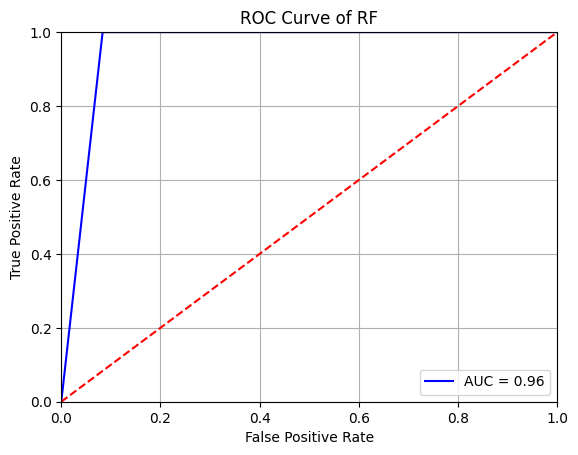

In [ ]:
inputimage_shape = (512, )
test_data = pd.read_csv("/content/drive/MyDrive/train_face/test_data/test_faces.csv")
embedder = FaceNet()
videos = test_data["vids_list"]
true_labels = test_data["label"]
print("Dataset Loaded...")
print(len(videos), len(true_labels))
testing_embeddings = create_base_network((512, ),
                      embedding_size=64)
model = load_model("/content/drive/MyDrive/train_face/triplets_semi_hard.hdf5",
  custom_objects={'triplet_loss_adapted_from_tf':triplet_loss_adapted_from_tf})
for layer_target, layer_source in zip(testing_embeddings.layers, model.layers[2].layers):
  weights = layer_source.get_weights()
  layer_target.set_weights(weights)
  del weights 
print("Model Loaded...")
y_predictions = []
y_probabilities = []
c= 0
test_label = np.load("/content/drive/MyDrive/train_face/test_data/test_labels.npy")
for i in videos:
  cap = cv2.VideoCapture(i)
  batches = []
  mounting = 0
  while(cap.isOpened() and mounting<25):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
      break		
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    face = mtcnn(frame)
    
    try:
      face = face.permute(1, 2, 0).int().numpy()
      batches.append(face)
    except AttributeError:
      print("Image Skipping")
    mounting+=1

  batches = np.asarray(batches).astype('float32')
  print(batches.shape)

  embeddings = embedder.embeddings(batches)
  x_test = testing_embeddings.predict(embeddings)
  sgd = linear_model.SGDClassifier(max_iter=50, tol=None)
  with open('/content/drive/MyDrive/train_face/rf_classifier.pkl', 'rb') as fid:
    sgd_loaded = pickle.load(fid)
  y_pred = sgd_loaded.predict(x_test)
  y_probabs = sgd_loaded.predict_proba(x_test)

  pred_mean = np.mean(y_pred, axis=0)
  probab_mean = np.mean(y_probabs, axis=0)
  # probab_mean = 1 - probab_mean

  y_probabilities +=[probab_mean]
  if pred_mean<0.5:
    y_predictions+=[0]
  else:
    y_predictions+=[1]

y_probabilities = np.array(y_probabilities)
fpr, tpr, threshold = roc_curve(test_label, y_probabilities[:, 1])
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print(EER)
roc_auc = auc(fpr, tpr)
print("AUC Score:", roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.grid()
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RF')
plt.savefig("AUC-ROC Score")

print("Accuracy:", accuracy_score(test_label, y_predictions))
print("Precision:", precision_score(test_label, y_predictions))
print("Recall:", recall_score(test_label, y_predictions))
print("F1 score:", f1_score(test_label, y_predictions))
